# In this Casestudy lets understand Statefull, Bidirectional LSTMS's using Reuters newswire classification dataset

### Import Section

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional,Input,Flatten
from keras.datasets import reuters
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,mean_absolute_error
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,LearningRateScheduler,ReduceLROnPlateau,TensorBoard
import datetime
from tensorflow.keras import Model
from math import sqrt
#!pip install keras-tuner 
import os
#import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from keras.utils.np_utils import to_categorical

## Lets pull newswire dataset

In [2]:
n_unique_words = 10000 # cut texts after this number of words
batch_size = 128 
(X_train, y_train),(X_test, y_test) = reuters.load_data(num_words=n_unique_words) 


2110848/2110848 [==============================] - 1s 1us/step


In [3]:
np.unique(y_test)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45])

## Lets understand the statistics of word length of the newswire dataset

100%|██████████| 8982/8982 [00:00<00:00, 601703.19it/s]


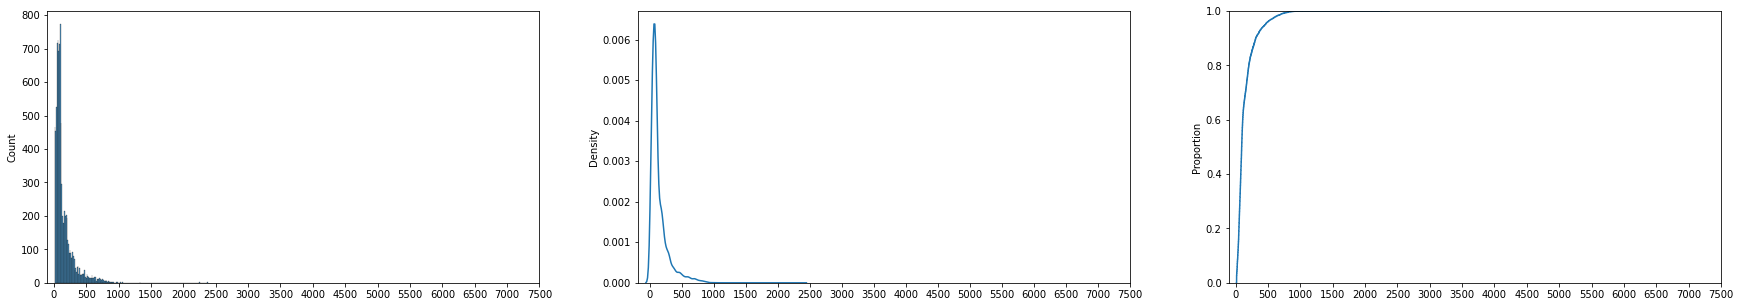

In [4]:
train_data_lengths = []
for review in tqdm(X_train):
  train_data_lengths.append(len(review))
fig, axs = plt.subplots(ncols=3,figsize=(30,5))
a = sns.histplot(data = train_data_lengths,ax=axs[0])
a.set_xticks(range(0,8000,500))
b = sns.kdeplot(data = train_data_lengths,ax=axs[1])
b.set_xticks(range(0,8000,500))
c = sns.ecdfplot(data = train_data_lengths,ax=axs[2])
c.set_xticks(range(0,8000,500))
plt.show()


In [5]:
maxlen = 1000
X_train = pad_sequences(X_train, maxlen=maxlen,padding='post',truncating='post')
X_test = pad_sequences(X_test, maxlen=maxlen,padding='post',truncating='post')
y_train = np.array(to_categorical(y_train))
y_test = np.array(to_categorical(y_test))

In [6]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8982, 1000)
(2246, 1000)
(8982, 46)
(2246, 46)


In [20]:
batch_size = 128
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_data = train_data.repeat().batch(batch_size, drop_remainder=True)
steps_per_epoch_train = len(X_train) // batch_size 
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_data = test_data.repeat().batch(batch_size, drop_remainder=True)
steps_per_epoch_test = len(X_test) // batch_size 

## Lets use keras tuner and do hyper parameter tuning

In [21]:
# write the architecture of the model
#print model.summary and make sure that it is following point 2 mentioned above
tf.keras.backend.clear_session()
inp = Input(shape=(maxlen,),batch_size=batch_size)
x = Embedding(n_unique_words, 300,input_length=maxlen)(inp)
x = Bidirectional(LSTM(units = 150,activation='tanh',kernel_initializer = 'he_normal',return_sequences = True,stateful = True))(x)
x = Bidirectional(LSTM(units = 100,activation='tanh',kernel_initializer = 'he_normal',return_sequences = True,stateful = True))(x)
#x = Bidirectional(LSTM(units = 150,activation='tanh',kernel_initializer = 'he_normal',return_sequences = True))(x)
#x = Bidirectional(LSTM(units = 100,activation='tanh',kernel_initializer = 'he_normal',return_sequences = True))(x)
x = tf.math.reduce_mean(x, axis = -1)
#x = Flatten()(x)
x = Dense(150, activation = 'relu', kernel_initializer = 'he_normal')(x)
x = Dropout(0.5)(x)
out = Dense(46, activation = 'softmax', kernel_initializer = 'he_normal')(x)
model = Model(inputs = inp, outputs = out)
#printing the model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(128, 1000)]             0         
                                                                 
 embedding (Embedding)       (128, 1000, 300)          3000000   
                                                                 
 bidirectional (Bidirectiona  (128, 1000, 300)         541200    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (128, 1000, 200)         320800    
 nal)                                                            
                                                                 
 tf.math.reduce_mean (TFOpLa  (128, 1000)              0         
 mbda)                                                           
                                                             

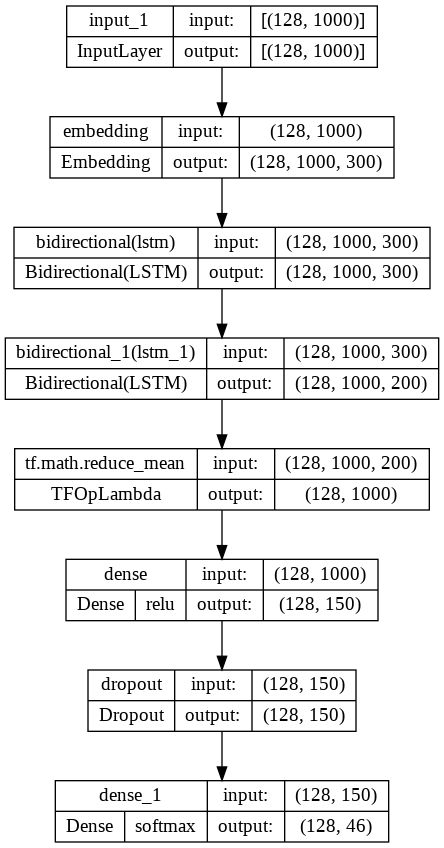

In [22]:
plot_model(model,show_shapes=True,show_layer_activations = True)

In [25]:
!mkdir /content/models
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
for i in range(10):
    model.fit(train_data, epochs=1, batch_size=batch_size, steps_per_epoch = steps_per_epoch_train,verbose=1, shuffle=False,validation_data= test_data,validation_steps = steps_per_epoch_test,validation_batch_size = batch_size)
    model.layers[2].reset_states()
    model.layers[3].reset_states()
    if (i+1) % 5 == 0:
      path = '/content/models/epoch_'+str(i)
      model.save(path)
    

mkdir: cannot create directory ‘/content/models’: File exists
70/70 [==============================] - 32s 456ms/step - loss: 0.6177 - accuracy: 0.8327 - val_loss: 1.7440 - val_accuracy: 0.6328


70/70 [==============================] - 32s 461ms/step - loss: 0.5453 - accuracy: 0.8483 - val_loss: 2.2097 - val_accuracy: 0.6466


In [28]:
reconstructed_model = tf.keras.models.load_model('/content/models/epoch_9')
reconstructed_model.evaluate(test_data,batch_size = batch_size, steps = steps_per_epoch_test)

17/17 [==============================] - 4s 150ms/step - loss: 2.2193 - accuracy: 0.6484


[2.219301700592041, 0.6484375]